In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import cv2
import imageio
import matplotlib.image as mpimg
from skimage import io
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import RMSprop,SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from statistics import mode
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalMaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-06-02 18:13:48.526076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 18:13:48.526180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 18:13:48.624504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


def prepare_dataset(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224, 224), cv2.INTER_AREA)
            img=img/255.0
            img_rgb = gray2RGB(img)
            if i < 100000:
                
                x_data.append(img_rgb)
                dataX.append(img_rgb)
                y_data.append(label)
                dataY.append(label)
            else: 
                break
            
            i = i + 1
    
    return  np.array(dataX),np.array(dataY)

In [2]:


def prepare_dataset_2(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224, 224), cv2.INTER_AREA)
            img_rgb = gray2RGB(img)
            lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
            l = lab[:,:,0]
            a = lab[:,:,1]
            b = lab[:,:,2]
            
            #Geleneksel equalazation yapalım.
            equalized = cv2.equalizeHist(l)
            
            #Kanalları birleştirelim.
            lab_img1_result = cv2.merge((equalized,a,b))
            
            #Lab formatımızı eski haline bgr haline dönüştürelim
            hist_eq_img = cv2.cvtColor(lab_img1_result, cv2.COLOR_LAB2BGR)
            hist_eq_img = hist_eq_img/255
            
            results = lab_img1_result / 255
            
            if i < 1500: 
                x_data.append(hist_eq_img)
                dataX.append(hist_eq_img)
                y_data.append(label)
                dataY.append(label)
            else:
                break
            
            i = i + 1
    
    return  np.array(dataX),np.array(dataY)


def prepare_dataset_clahe(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224, 224), cv2.INTER_AREA)
            img_rgb = gray2RGB(img)
            lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
            l = lab[:,:,0]
            a = lab[:,:,1]
            b = lab[:,:,2]
            
            #Geleneksel equalazation yapalım.
            equalized = cv2.equalizeHist(l)
            
            #Kanalları birleştirelim.
            lab_img1_result = cv2.merge((equalized,a,b))
            
            #Lab formatımızı eski haline bgr haline dönüştürelim
            hist_eq_img = cv2.cvtColor(lab_img1_result, cv2.COLOR_LAB2BGR)
            hist_eq_img = hist_eq_img/255
            
            results = lab_img1_result / 255
            
            if i < 1800:
                x_data.append(hist_eq_img)
                dataX.append(hist_eq_img)
                y_data.append(label)
                dataY.append(label)
            else: 
                break
                
            i = i + 1
            
    return  np.array(dataX),np.array(dataY)




In [3]:
def gray2RGB(array2d):
    array3d = np.tile(array2d[:,:,np.newaxis],3)
    return array3d

def all_img_rgb_converter(arrays2d):

    len, width, height = arrays2d.shape
    arrays3d = []

    for i in range(len):
        array3d = gray2RGB(arrays2d[i,:,:])
        arrays3d.append(array3d)

    arrays3d = np.array(arrays3d)
    return arrays3d

In [4]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [5]:
def accuracy_lr_loss_plot(history):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(231)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(232)
    plt.plot(history.history['learning_rate'], 'go--', label="Learning Rate")
    plt.title("Learning Rate")
    plt.xlabel("Number of epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    
    plt.subplot(233)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()


In [6]:
x_data = []
y_data = []


In [7]:
Mild_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented"
Moderate_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented"
Non_Demented_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented"
Very_mild_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented"


In [8]:
Mild_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented"
Moderate_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented"
Non_Demented_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented"
Very_mild_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented"


In [9]:
X_Mild_Dementia_test, Y_Mild_Dementia_test =  prepare_dataset_clahe(Mild_Dementia_test,0)
X_Moderate_Dementia_test, Y_Moderate_Dementia_test =  prepare_dataset_clahe(Moderate_Dementia_test,0)
X_Non_Demented_test, Y_Non_Demented_test = prepare_dataset_2(Non_Demented_test,1)
X_Very_mild_Dementia_test, Y_Very_mild_Dementia_test = prepare_dataset_clahe(Very_mild_Dementia_test,0)

In [10]:
X_Mild_Dementia_train, Y_Mild_Dementia_train =  prepare_dataset_clahe(Mild_Dementia_train,0)
X_Moderate_Dementia_train, Y_Moderate_Dementia_train =  prepare_dataset_clahe(Moderate_Dementia_train,0)
X_Non_Demented_train, Y_Non_Demented_train = prepare_dataset_2(Non_Demented_train,1)
X_Very_mild_Dementia_train, Y_Very_mild_Dementia_train = prepare_dataset_clahe(Very_mild_Dementia_train,0)

In [11]:
X_Mild_Dementia_train.shape

(717, 224, 224, 3)

In [12]:
c_0 = 0
c_1 = 0
    
for i in y_data:
    if i == 0:
        c_0 += 1 
    elif i == 1:
        c_1 += 1
    else:
        print("asfaa")

In [13]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50

In [14]:
pretrained_model=ResNet50(input_shape = (224, 224, 3), 
                              include_top = False, 
                              weights = 'imagenet')

for layer in pretrained_model.layers:
        layer.trainable = False
        
for layer in pretrained_model.layers[143:]:
        layer.trainable = True

In [15]:
#for i, layer in enumerate(pretrained_model.layers):
#    print(i,'\t',layer.trainable,'\t  :',layer.name)

In [16]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 5)


In [17]:
VALIDATION_ACCURACY_ResNet50 = []
VALIDAITON_LOSS_ResNet50 = []

fold-1 data verileri atlandı
fold-2 data verileri atlandı
fold-3 data verileri atlandı
fold-4 data verileri atlandı
Epoch 1/50


I0000 00:00:1717352128.042798    3754 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717352128.112482    3754 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5144 - loss: 1.0157

W0000 00:00:1717352159.354940    3754 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717352165.629512    3754 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.59457, saving model to /kaggle/working/ResNet50_model_5.keras


W0000 00:00:1717352171.208943    3757 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/134 ━━━━━━━━━━━━━━━━━━━━ 81s 341ms/step - accuracy: 0.5147 - loss: 1.0142 - val_accuracy: 0.5946 - val_loss: 288.0229 - learning_rate: 0.0100
Epoch 2/50
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5574 - loss: 0.7127
Epoch 2: val_accuracy did not improve from 0.59457
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.5578 - loss: 0.7124 - val_accuracy: 0.4054 - val_loss: 8.8122 - learning_rate: 0.0100
Epoch 3/50
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6521 - loss: 0.6371
Epoch 3: val_accuracy did not improve from 0.59457
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.6524 - loss: 0.6367 - val_accuracy: 0.4054 - val_loss: 10.0919 - learning_rate: 0.0100
Epoch 4/50
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7202 - loss: 0.5678
Epoch 4: val_accuracy did not improve from 0.59457

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.7203 - loss: 0.5676 

W0000 00:00:1717352809.228408    3757 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step


W0000 00:00:1717352814.602370    3757 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<Figure size 640x480 with 0 Axes>

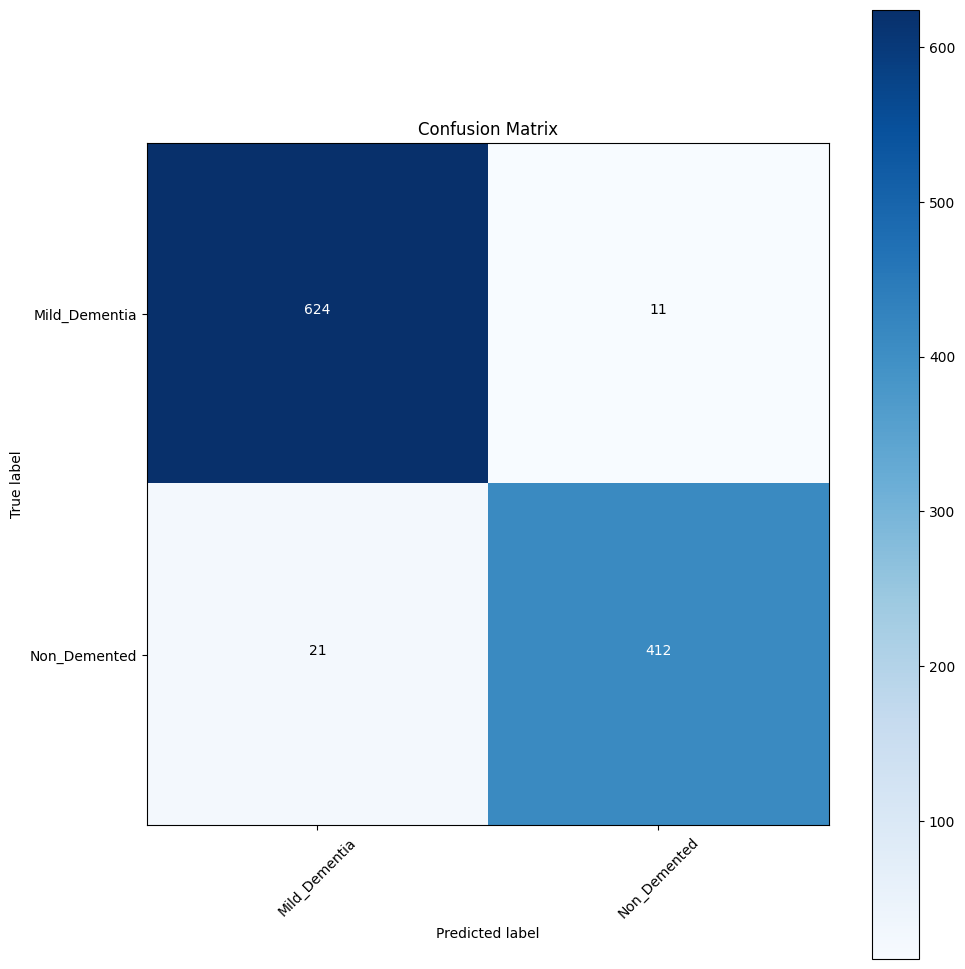

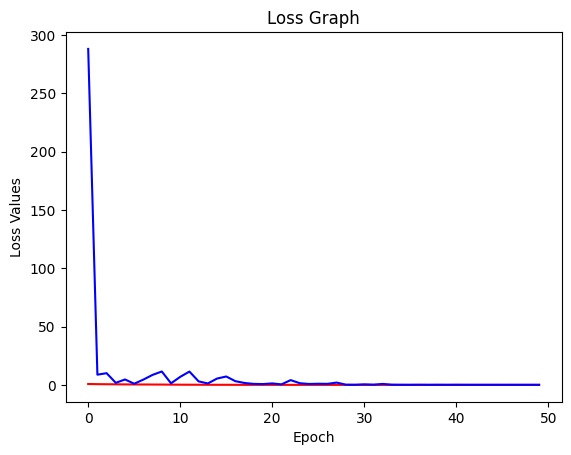

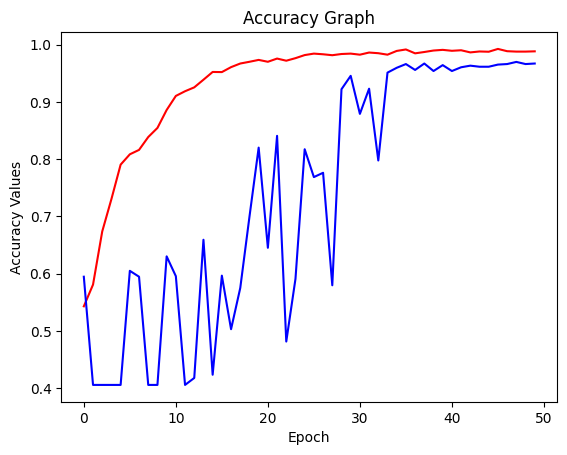

[0.9700374603271484]
[0.13891874253749847]


<Figure size 640x480 with 0 Axes>

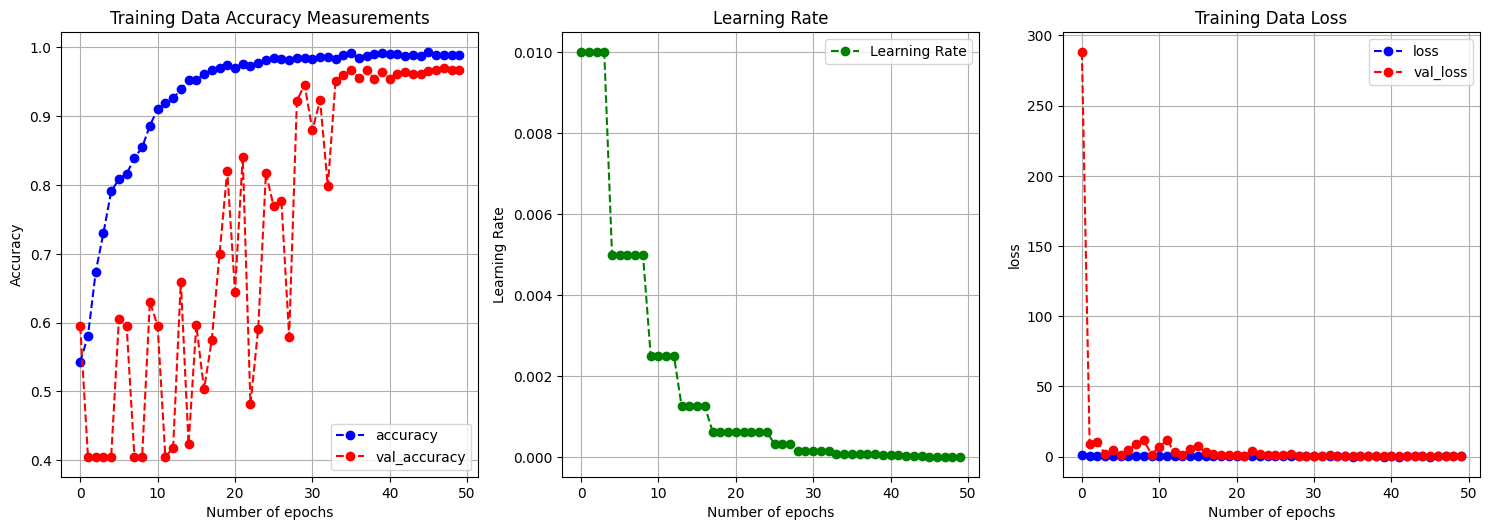

In [18]:
fold_var = 1

desired_fold = 5

for train_index, val_index in kf.split(x_data,y_data):
    
    if fold_var == desired_fold: 
        x_train_data = []
        y_train_data = []

        x_val_data = []
        y_val_data = []


        for i in train_index:
          x_train_data.append(x_data[i])
          y_train_data.append(y_data[i])


        for i in val_index:
          x_val_data.append(x_data[i])
          y_val_data.append(y_data[i])


        X_train = np.array(x_train_data)
        Y_train = np.array(y_train_data)

        X_val = np.array(x_val_data)
        Y_val = np.array(y_val_data)

        ################# ResNet50 ##################
        pretrained_model=ResNet50(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet')

        for layer in pretrained_model.layers:
            layer.trainable = False

        for layer in pretrained_model.layers[143:]:
            layer.trainable = True


        # Define custom head for classification
        x = pretrained_model.output
        # x = Dropout(0.5)(x)
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(8192, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(4096, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2048, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        output = Dense(2, activation='softmax')(x)



        final_ResNet50 = Model(inputs=pretrained_model.input, outputs=output)



        final_ResNet50.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
                        loss = 'sparse_categorical_crossentropy', 
                        metrics = ['accuracy'])


        #.h5 = Hierarchical Data Format Ver. 5 file, verbose =1, to see execution
        tensorboard= tf.keras.callbacks.TensorBoard(log_dir="logs")
        checkpoint= tf.keras.callbacks.ModelCheckpoint(f"/kaggle/working/ResNet50_model_{fold_var}.keras",
                                monitor="val_accuracy", verbose=1,
                                mode="auto", save_best_only=True)

        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)


        #monitor: quantity to be monitored.     
        #factor: factor by which the learning rate will be reduced. 
        #patience: number of epochs with no improvement after which learning rate will be reduced.     
        #verbose: int. 0: quiet, 1: update messages.
        #min_delta: early stopping of epochs
        reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                factor=0.5,
                                patience=3,verbose=1,
                                mode="auto", min_delta=0.001)



        history = final_ResNet50.fit(X_train,Y_train,
                epochs=50,
                validation_data=(X_val,Y_val),
                callbacks =[tensorboard, checkpoint, reduce_lr])



        # LOAD BEST MODEL to evaluate the performance of the model
        final_ResNet50.load_weights(f"/kaggle/working/ResNet50_model_{fold_var}.keras")

        results = final_ResNet50.evaluate(X_val,Y_val)
        results = dict(zip(final_ResNet50.metrics_names,results))


        VALIDATION_ACCURACY_ResNet50.append(results['compile_metrics'])
        VALIDAITON_LOSS_ResNet50.append(results['loss'])


        #  Logic of all test database
        Y_pred = final_ResNet50.predict(X_val)
        Y_pred = np.argmax(Y_pred, axis=1)


        #  Return pro format of classes
        target_names = ["Mild_Dementia", "Non_Demented"]

        # Confusion Matrix
        plt.figure()
        cm = confusion_matrix(Y_val, Y_pred)
        plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

        # Save confusion matrix in text
        np.savetxt(f"/kaggle/working/ResNet50_cm_{fold_var}.txt",cm,fmt='%d')
        plt.savefig(f"/kaggle/working/ResNet50_cm_img_{fold_var}.png")

        # Save clasification report in text
        text_file = open(f"/kaggle/working/ResNet50_report_{fold_var}.txt", "w")
        n = text_file.write(classification_report(Y_val, Y_pred, target_names=target_names))
        text_file.close()

        #Comparing losses and accuraries 
        plt.figure()
        plt.plot(history.history['loss'], color='r')
        plt.plot(history.history['val_loss'], color='b')
        plt.title("Loss Graph")
        plt.xlabel("Epoch")
        plt.ylabel("Loss Values")
        plt.savefig(f"/kaggle/working/ResNet50_loss_{fold_var}.png")
        plt.show()

        plt.figure()
        plt.plot(history.history['accuracy'], color='r')
        plt.plot(history.history['val_accuracy'], color='b')
        plt.title("Accuracy Graph")
        plt.ylabel("Accuracy Values")
        plt.xlabel("Epoch")
        plt.savefig(f"/kaggle/working/ResNet50_accuracy_{fold_var}.png")
        plt.show()

        plt.figure()
        print(VALIDATION_ACCURACY_ResNet50)
        print(VALIDAITON_LOSS_ResNet50)
        
        acc_file = open(f"/kaggle/working/acc_loss_results.txt", "w")
        n = acc_file.write(str(VALIDATION_ACCURACY_ResNet50))
        n2 = acc_file.write(str(VALIDAITON_LOSS_ResNet50))
        acc_file.close()

        accuracy_lr_loss_plot(history)

    
    elif fold_var != desired_fold:
        print(f"fold-{fold_var} data verileri atlandı")
    else:
        print("yanlış bişeyler var hacı")
        
    fold_var += 1
    tf.keras.backend.clear_session() 
    
    